<a href="https://colab.research.google.com/github/jay-D-Deshmukh/Automatic-No-Plate-Recognition-Parking-Sysem/blob/main/Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv("/content/drive/MyDrive/Data sets/Fraud.csv")

In [6]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Columns info
step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [7]:
print("The total no of Row"  ,data.shape[0])
print("-"*30)
print("The total no of Columns"  ,data.shape[1])

The total no of Row 6362620
------------------------------
The total no of Columns 11


In [8]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<Axes: >

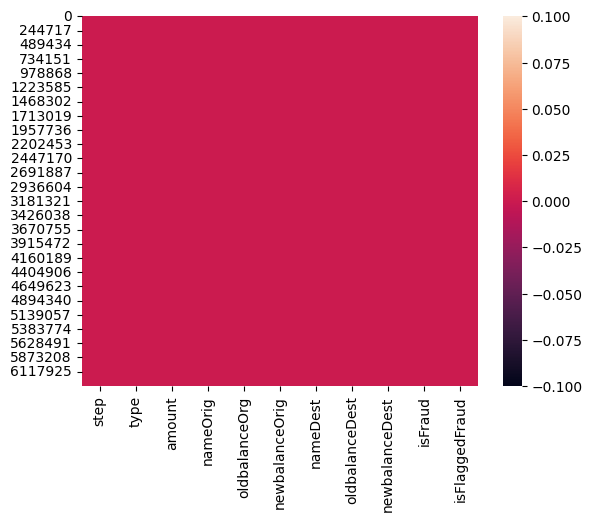

In [9]:
sns.heatmap(data.isnull())

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [11]:
data.duplicated().sum()

0

In [12]:
data.describe(include = 'all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


In [13]:
data['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [14]:
data['step'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [15]:
data['isFraud'].unique()

array([0, 1])

In [16]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

**Here we found that, Data is imbalance as  1  that is Fraud Transction is in less no**

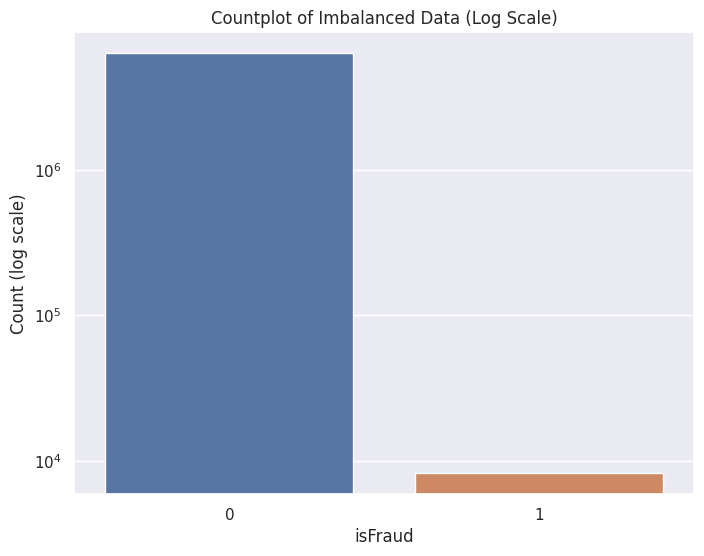

In [17]:

sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=data['isFraud'], data=data)

# Set a log scale on the y-axis
ax.set_yscale('log')

# Add labels and title
plt.title('Countplot of Imbalanced Data (Log Scale)')
plt.xlabel('isFraud')
plt.ylabel('Count (log scale)')

# Show the plot
plt.show()



**In real-world scenarios, fraudulent transactions are relatively rare compared to legitimate ones. For example, in credit card transactions, the vast majority of transactions are legitimate, while only a small fraction are fraudulent.**

**Imbalanced data can lead to biased models that have high accuracy in classifying genuine transactions but perform poorly in detecting fraud. This is because the model may learn to always predict the majority class, achieving high accuracy but failing to catch the important minority class**

**Traditional accuracy is not an appropriate metric for evaluating the performance of a model on imbalanced data. Instead, metrics like precision, recall, F1-score, and area under the precision-recall curve (AUC-PR) are more informative. Precision measures the accuracy of positive predictions, while recall measures the ability to capture all positive instances.**

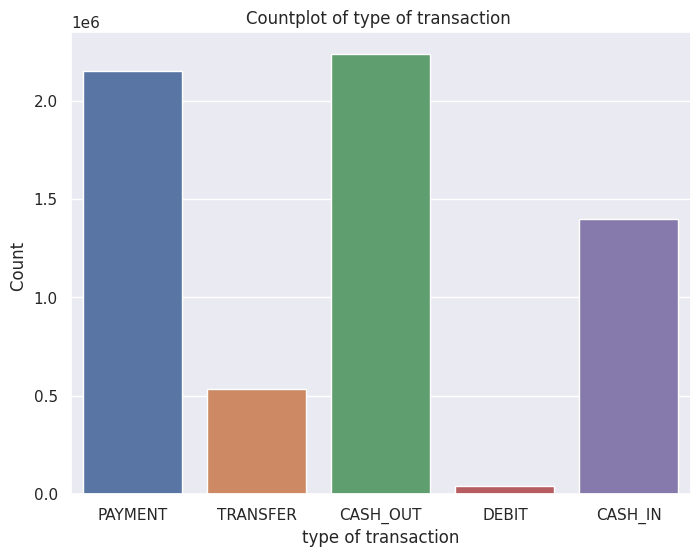

In [18]:

sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=data['type'], data=data)
# Add labels and title
plt.title('Countplot of type of transaction ')
plt.xlabel('type of transaction')
plt.ylabel('Count ')

# Show the plot
plt.show()

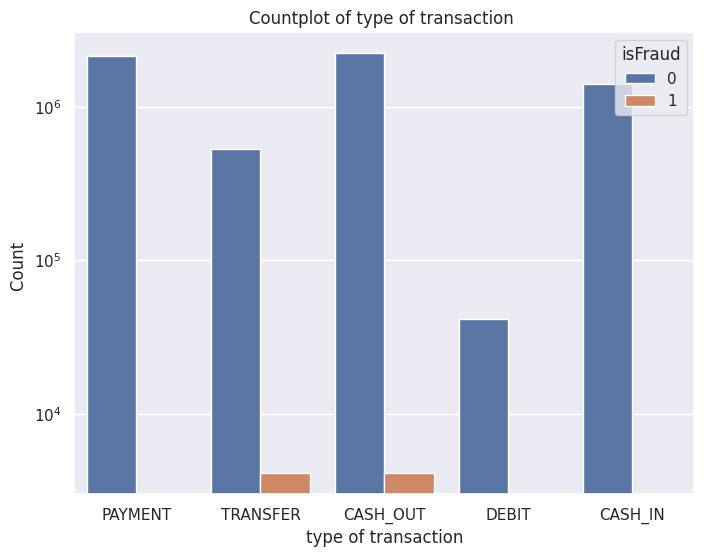

In [19]:

sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=data['type'], hue = 'isFraud',data=data)
ax.set_yscale('log')
# Add labels and title
plt.title('Countplot of type of transaction ')
plt.xlabel('type of transaction')
plt.ylabel('Count ')

# Show the plot
plt.show()

**Here is the most imp information we found out , that the fraud transaction is strong associate with transaction type transfer and cash_out**

# EDA on Fraud Data (type and amount)

In [20]:
sub_data = data[data['isFraud'] == 1][['amount','type']]

In [21]:
sub_data.describe()

,amount
count,8.213000e+03
mean,1.467967e+06
std,2.404253e+06
min,0.000000e+00
25%,1.270913e+05
50%,4.414234e+05
75%,1.517771e+06
max,1.000000e+07


In [22]:
sub_data['amount'].mean()

1467967.299140387

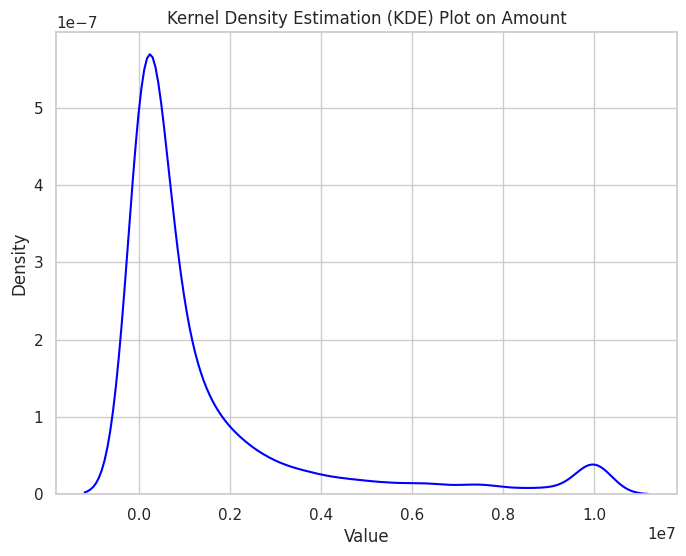

In [23]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.kdeplot(sub_data['amount'],color="blue")
ax.set_yscale('log')
# Add labels and title
plt.title('Kernel Density Estimation (KDE) Plot on Amount')
plt.xlabel('Value')
plt.ylabel('Density')

# Show the plot
plt.show()

**In a right-skewed distribution, the KDE plot will show a long, stretched-out tail on the right side.
The peak of the KDE curve will be on the left side, where the data is more concentrated.**

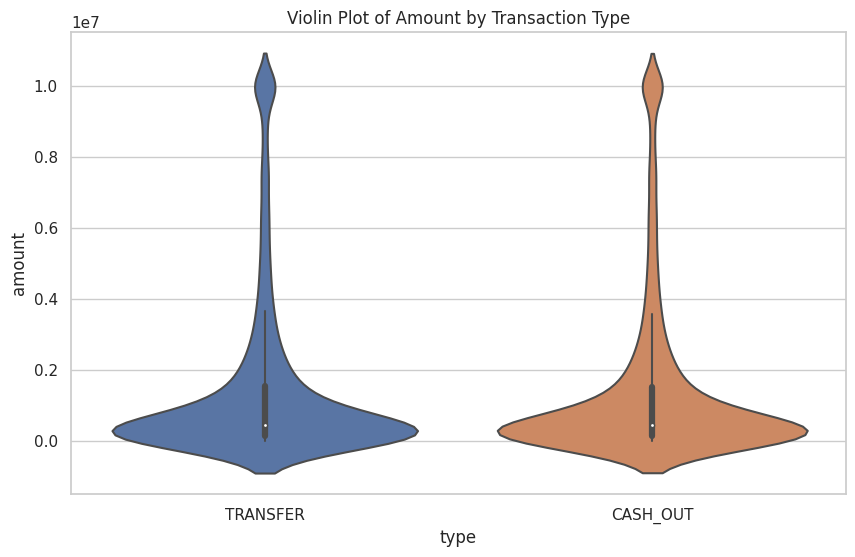

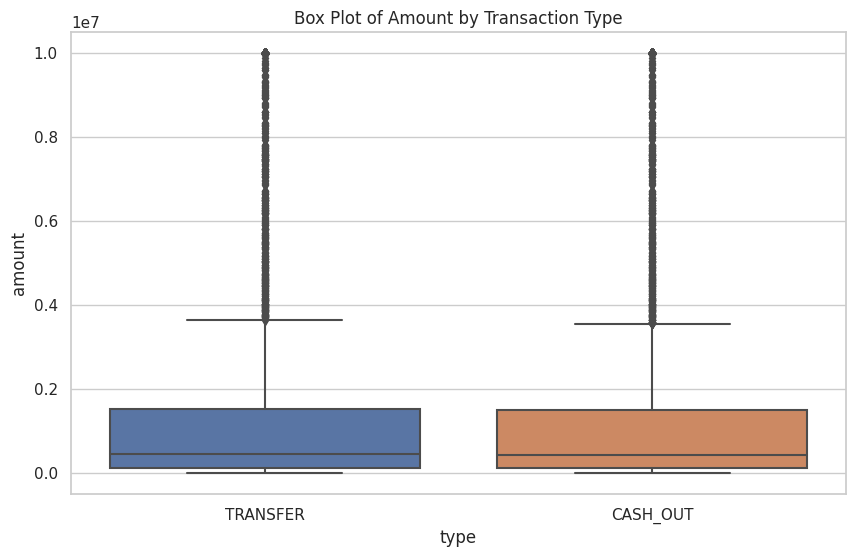

In [24]:
# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='type', y='amount', data=sub_data)
plt.title('Violin Plot of Amount by Transaction Type')
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='amount', data=sub_data)
plt.title('Box Plot of Amount by Transaction Type')
plt.show()


**Data amount of fraud transcation is having larage amount of utliers**

**When dealing with columns that have a large amount of outliers, it's important to understand the implications and potential strategies for handling them. Outliers are data points that significantly deviate from the rest of the data in a column, and they can have a substantial impact on statistical analyses and machine learning models.**

<ipython-input-25-f7946d67b048>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


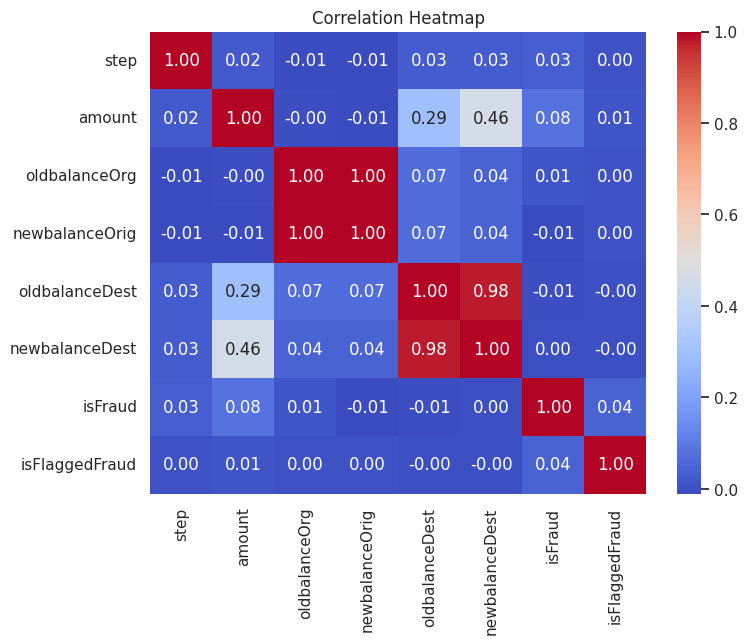

In [25]:
corr_matrix = data.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add title
plt.title("Correlation Heatmap")

# Show the plot
plt.show()

** fraud detection dataset, it becomes crucial to address this issue as it can impact the effectiveness of the predictive model. Here are some points you can write about finding multicollinearity in a credit card fraud detection dataset: **

Introduction to Multicollinearity:

Start by explaining what multicollinearity is. In the context of credit card fraud detection, it refers to high correlation between predictor variables, which can complicate the model's ability to accurately identify fraudulent transactions.
Signs of Multicollinearity **bold text**: *italicized text*

Describe the signs that indicate the presence of multicollinearity in the dataset:
High correlation coefficients between predictor variables.
Elevated Variance Inflation Factors (VIFs) for certain variables**

# EDA on non Fraud data

In [26]:
sub_data_0 = data[data['isFraud'] == 0][['amount','type','step',	'nameOrig',	'oldbalanceOrg',	'newbalanceOrig'	,'nameDest',	'oldbalanceDest','newbalanceDest','isFlaggedFraud']]

In [27]:
sub_data_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6354407 entries, 0 to 6362323
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   amount          float64
 1   type            object 
 2   step            int64  
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFlaggedFraud  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 533.3+ MB


In [28]:
sub_data_0.describe()

,amount,step,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
count,6.354407e+06,6.354407e+06,6.354407e+06,6.354407e+06,6.354407e+06,6.354407e+06,6354407.0
mean,1.781970e+05,2.432357e+02,8.328287e+05,8.559702e+05,1.101421e+06,1.224926e+06,0.0
std,5.962370e+05,1.421402e+02,2.887144e+06,2.924987e+06,3.399202e+06,3.673816e+06,0.0
min,1.000000e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.336840e+04,1.560000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,7.468472e+04,2.390000e+02,1.406900e+04,0.000000e+00,1.333118e+05,2.148817e+05,0.0
75%,2.083648e+05,3.340000e+02,1.069695e+05,1.447307e+05,9.441446e+05,1.111975e+06,0.0
max,9.244552e+07,7.180000e+02,4.381886e+07,4.368662e+07,3.560159e+08,3.561793e+08,0.0


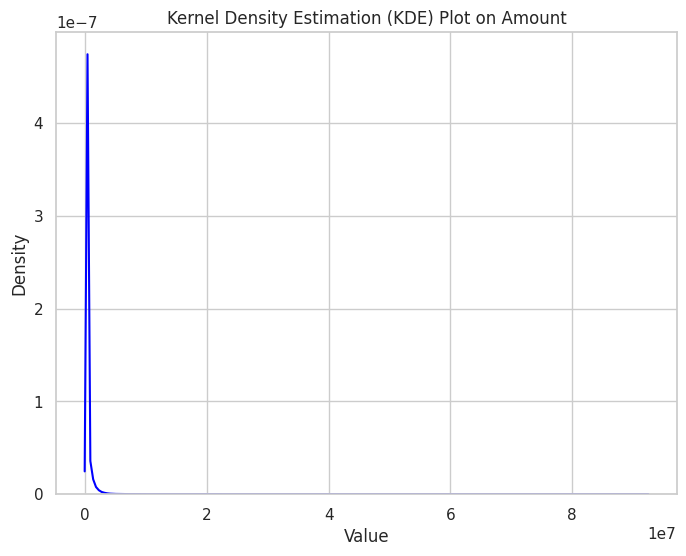

In [29]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.kdeplot(sub_data_0['amount'],color="blue")
ax.set_yscale('log')
# Add labels and title
plt.title('Kernel Density Estimation (KDE) Plot on Amount')
plt.xlabel('Value')
plt.ylabel('Density')

# Show the plot
plt.show()

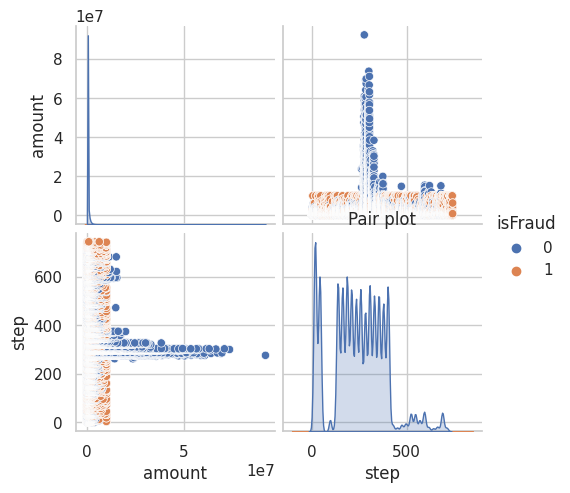

In [31]:
data_set_pair = data[['amount','type','step','isFraud']]
sns.pairplot(data_set_pair, diag_kind='kde', markers='o', hue='isFraud')
plt.title('Pair plot')
plt.show()


# Model Building and data preprocessing

In [32]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [33]:
data.drop(columns = ['nameDest','nameOrig'] , inplace = True)

In [34]:
data['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [35]:
def convert(data):
  if data == 'PAYMENT':
    return 0
  if data == 'CASH_IN':
    return 1
  if data == 'DEBIT':
    return 2
  if data == 'TRANSFER':
    return 3
  else:
    return 4


In [36]:
data['type'] = data['type'].apply(convert)

# Preparing the x variables and y for model building

**Data is having high amount of muticolinarity**


To automate the process of eliminating variables based on their VIF values for a classification problem, you can follow these steps:

Calculate the VIF values for all variables.
Remove the variable with the highest VIF.
Repeat steps 1 and 2 until all remaining variables have VIF values below a specified threshold

In [38]:
data

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,0,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,1,0,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,1,3,181.00,181.00,0.00,0.00,0.00,1,0
3,1,4,181.00,181.00,0.00,21182.00,0.00,1,0
4,1,0,11668.14,41554.00,29885.86,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...
6362615,743,4,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,743,3,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,743,4,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,743,3,850002.52,850002.52,0.00,0.00,0.00,1,0


In [40]:
x_data = data[['amount','type','step','oldbalanceOrg',	'newbalanceOrig'	,'oldbalanceDest','newbalanceDest','isFlaggedFraud']]

In [43]:


# Select only numeric variables (VIF is applicable to numeric variables)
numeric_data = x_data

# Add a constant term (intercept) to the data
numeric_data['const'] = 1

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = numeric_data.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]

# Display the VIF values
print(vif_data)


         Variable         VIF
0          amount    3.712717
1            type    1.112583
2            step    1.002739
3   oldbalanceOrg  443.313478
4  newbalanceOrig  445.528313
5  oldbalanceDest   65.125694
6  newbalanceDest   75.140447
7  isFlaggedFraud    1.000587
8           const    5.468402


In [41]:


def calculate_vif(data):
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    numeric_data['const'] = 1

    vif_data = pd.DataFrame()
    vif_data["Variable"] = numeric_data.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]

    return vif_data

def eliminate_variable(data, threshold):
    vif_data = calculate_vif(data)

    while vif_data["VIF"].max() > threshold:
        max_vif_index = vif_data["VIF"].idxmax()
        variable_to_remove = vif_data.loc[max_vif_index, "Variable"]
        data = data.drop(variable_to_remove, axis=1)

        vif_data = calculate_vif(data)

    return data

# Example usage:
# Assuming 'X' is your feature DataFrame and 'threshold' is your VIF threshold
# Replace 'X' and 'threshold' with your actual data and threshold

# Set your VIF threshold (e.g., 5 is a common threshold)
threshold = 10

# Eliminate variables with high VIF
X = eliminate_variable(x_data, threshold)

# Now 'X' contains only variables with VIF values below the threshold


In [46]:
x = X
y = data['isFraud']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [49]:
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data (do NOT fit again)
X_test_scaled = scaler.transform(X_test)


Accuracy: 0.7215
Precision: 0.0037
Recall: 0.8093
F1 Score: 0.0074
Confusion Matrix:
[[1145943  442667]
 [    390    1655]]
AUC-ROC Score: 0.7653


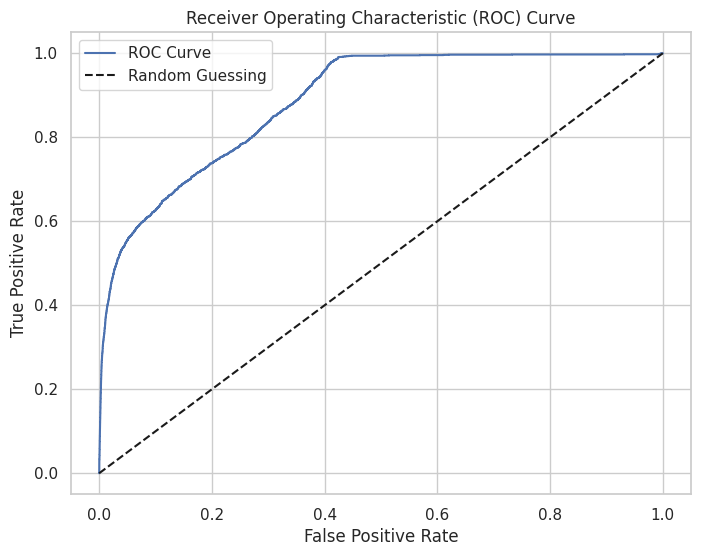

In [54]:

logistic_regression = LogisticRegression(random_state=42,class_weight='balanced')
logistic_regression.fit(X_train_scaled, y_train)

# Step 3: Predict on the test set
y_pred = logistic_regression.predict(X_test_scaled)

# Step 4: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{confusion}")
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Step 5: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, logistic_regression.predict_proba(X_test_scaled)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


The evaluation metrics you provided indicate that the model has some positive aspects but also some limitations. Let's break down the results:

- **Accuracy**: The accuracy of 0.7215 indicates that the model is correct about 72.15% of the time. While accuracy is a common metric, it can be misleading in imbalanced datasets, where the majority class dominates. In this case, it's more important to focus on other metrics.

- **Precision**: The precision of 0.0037 is quite low. It suggests that when the model predicts a transaction as fraud, it's correct only about 0.37% of the time. In other words, there are many false positives.

- **Recall**: The recall of 0.8093 is relatively high. It indicates that the model is able to correctly identify about 80.93% of actual fraud transactions. This is a positive aspect because it suggests the model is sensitive to detecting fraud cases.

- **F1 Score**: The F1 score of 0.0074 is a balance between precision and recall. It's relatively low, indicating that there is room for improvement in both precision and recall.

- **Confusion Matrix**: The confusion matrix shows that there are many false positives (442,667) and a relatively small number of true positives (1,655). The model seems to have a high rate of false alarms.

- **AUC-ROC Score**: The AUC-ROC score of 0.7653 is a measure of the model's ability to distinguish between the two classes. It's above 0.5, indicating that the model is better than random guessing, but there's still room for improvement.

In fraud detection, it's often more important to minimize false negatives (missed fraud cases) at the expense of increasing false positives (false alarms). You may consider adjusting the classification threshold to increase sensitivity (recall) even further while potentially accepting more false positives.

Additionally, you might want to explore more advanced techniques, such as anomaly detection algorithms or ensemble methods, to improve the model's performance on this highly imbalanced dataset.

Accuracy: 0.9996
Precision: 0.9348
Recall: 0.7154
F1 Score: 0.8105
Confusion Matrix:
[[1588508     102]
 [    582    1463]]
AUC-ROC Score: 0.8577


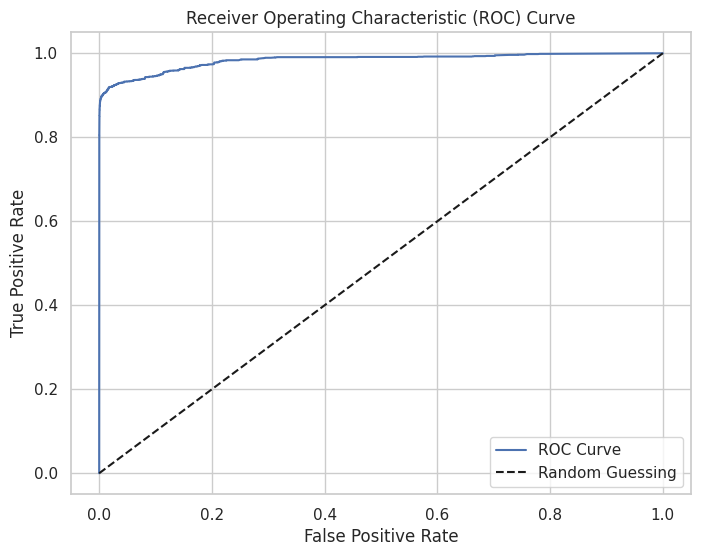

In [55]:

# Step 2: Initialize and train the Random Forest model
random_forest = RandomForestClassifier(random_state=42,class_weight='balanced')
random_forest.fit(X_train_scaled, y_train)

# Step 3: Predict on the test set
y_pred = random_forest.predict(X_test_scaled)

# Step 4: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{confusion}")
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Step 5: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, random_forest.predict_proba(X_test_scaled)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


Certainly! Let's go through the evaluation metrics for the classification problem with an imbalanced dataset:

- **Accuracy**:
  - Accuracy is the ratio of correctly predicted instances to the total instances. In this case, it's 99.96%.
  - However, accuracy can be misleading in imbalanced datasets because a high accuracy score can be achieved by simply predicting the majority class all the time.

- **Precision**:
  - Precision is the ratio of true positives to the total predicted positives.
  - A high precision (0.9348 in this case) indicates that when the model predicts a transaction as fraud, it is correct about 93.48% of the time. It's a measure of the accuracy of positive predictions.

- **Recall (Sensitivity)**:
  - Recall is the ratio of true positives to the total actual positives.
  - A recall of 0.7154 means that the model is able to correctly identify about 71.54% of actual fraud transactions. It's a measure of the ability to detect all the positives.

- **F1 Score**:
  - The F1 score is the harmonic mean of precision and recall.
  - It's a balance between precision and recall. A higher F1 score (0.8105) indicates a good balance between precision and recall.

- **Confusion Matrix**:
  - The confusion matrix shows the actual and predicted classes.
  - In this case, there are 1,463 true positives, 102 false positives, 582 false negatives, and 1,588,508 true negatives.

```
             Actual
              0        1
Predicted 0  1588508   102
          1  582       1463
```

- **AUC-ROC Score**:
  - The Area Under the Receiver Operating Characteristic Curve (AUC-ROC) is a measure of how well the model can distinguish between classes.
  - An AUC-ROC score of 0.8577 indicates a relatively good separation between the classes.

Overall, the model shows strong performance, particularly in terms of precision (high percentage of correct fraud predictions) and AUC-ROC score (good separation between classes). However, there is still room for improvement, especially in terms of recall, which represents the model's ability to detect all the actual fraud cases. Depending on the specific business context, you may need to fine-tune the model or try other techniques to further improve performance.